In [1]:
# Import Required Libraries
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import Data
# scraped data from Times of India twitter feed consisting of tweets having farmer as a string
data = pd.read_csv("farmer_tweets/timesofindia_tweets.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1618 entries, 0 to 1617
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   S.No.      1618 non-null   int64 
 1   Username   1618 non-null   object
 2   Datetime   1618 non-null   object
 3   Tweet_Url  1618 non-null   object
 4   Text       1618 non-null   object
 5   Likes      1618 non-null   object
 6   Retweets   1618 non-null   object
 7   Replies    1618 non-null   object
dtypes: int64(1), object(7)
memory usage: 101.2+ KB


In [3]:
# Lets drop the unnecessary columns from dataframe
data = data.drop(['S.No.', 'Username','Tweet_Url', 'Likes', 'Retweets', 'Replies'], axis = 1)
# Save original tweets in a new column
data['Original_Tweets'] = ""
data['Original_Tweets'] = data['Text']
data.head()

,Datetime,Text,Original_Tweets
0,2021-04-12 09:52:49+00:00,Didi is abusing BJP unnecessarily. You're mist...,Didi is abusing BJP unnecessarily. You're mist...
1,2021-04-11 05:20:00+00:00,"Citing Covid, Tomar asks farmers to call off t...","Citing Covid, Tomar asks farmers to call off t..."
2,2021-04-10 14:40:00+00:00,#FarmersProstest\n\nTomar appeals to farmers t...,#FarmersProstest\n\nTomar appeals to farmers t...
3,2021-04-10 10:27:50+00:00,"Many farmers unions, economists are supporting...","Many farmers unions, economists are supporting..."
4,2021-04-09 18:30:48+00:00,You have surrendered to Modi: Shiromani Akali ...,You have surrendered to Modi: Shiromani Akali ...


In [4]:
# Clean datetime since I only need the dates. I will be grouping the tweets based on the day, and 
# use it to understand what happened that day.
data['Datetime'] = data['Datetime'].str.slice(0, 10, 1)
data.head()

,Datetime,Text,Original_Tweets
0,2021-04-12,Didi is abusing BJP unnecessarily. You're mist...,Didi is abusing BJP unnecessarily. You're mist...
1,2021-04-11,"Citing Covid, Tomar asks farmers to call off t...","Citing Covid, Tomar asks farmers to call off t..."
2,2021-04-10,#FarmersProstest\n\nTomar appeals to farmers t...,#FarmersProstest\n\nTomar appeals to farmers t...
3,2021-04-10,"Many farmers unions, economists are supporting...","Many farmers unions, economists are supporting..."
4,2021-04-09,You have surrendered to Modi: Shiromani Akali ...,You have surrendered to Modi: Shiromani Akali ...


In [5]:
# Looking at the Text column to understand the data
data['Text'].head(30)

0     Didi is abusing BJP unnecessarily. You're mist...
1     Citing Covid, Tomar asks farmers to call off t...
2     #FarmersProstest\n\nTomar appeals to farmers t...
3     Many farmers unions, economists are supporting...
4     You have surrendered to Modi: Shiromani Akali ...
5     #FarmersProtests\n\nProtesting farmers to bloc...
6     Punjab bows to Centre, agrees to transfer cash...
7     Not even fear of #COVID19 can disrupt protest,...
8     Spurt in Covid-like symptoms at Singhu border,...
9     SC impleads UP and Haryana governments on farm...
10    #JustIn \n\nSC reiterates that public roads ca...
11    Punjab bows to Centre, agrees to transfer cash...
12    Six caught for billionaire farmer’s murder in ...
13    Govt shouldn't treat farmers' stir like Shahee...
14    Compensate farmers for crop damage by animals ...
15    FCI Delhi region is fully prepared to procure ...
16    Procurement: Punjab had agreed to DBT for farm...
17    Bengal polls: Lotus in bloom, good news fo

In [6]:
# These are tweets, remember, not headlines.
# These tweets need to be cleaned. Remove Hashtags, punctuations, links, stopwords etc
data['Text'][0]

"Didi is abusing BJP unnecessarily. You're mistaken that BJP is contesting against you. It is the mothers, sisters of North Bengal, Rajbongshi community, the Gorkha community, the tea workers, the farmers who are contesting against you: Amit Shah in Dhupguri, WB (ANI) https://t.co/voTBvl1Gp3"

In [7]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
# Data Specific stopwords
data_stop_words = ['live', 'update', 'updates', 'breaking', 'news', 'todays', 'amp', 'via', 'read', 'ani', 'pti',
                  'click', 'subscribe', 'special', 'story', 'stories', 'curated', 'editors', 'delivered', 'inbox',
                  'edit', 'photo', 'photos', 'pic', 'pics', 'screenshot', 'qampa'
                  'timesofindia', 'toiworld', 'toinoida', 'toibusiness', 'toi', 'toiquickedit', 'budgetwithtimes',
                  'toicitiesnews', 'toilucknow', 'toihyderabad', 'toidelhi', 'toibengaluru', 'toichennai', 'ji']

In [9]:
# Cleaning Data
# 1. Removing New lines
# 2. Removing Links
# 3. Lowercase
# 4. Removing English Based Stopwords 
# 5. Removing Data Specific Stopwords
# 6. Remove Hashtags (different from punctuations, since #isconnectedtothephrase --> remove the phrase too)
# 7. Remove @User type thing too
# 8. Remove punctuations
# 9. Some stopwords remain since words may be joined with a punctuation. eg. hello!
# 10. Remove single alphabets and extra spaces

# maybe remove numbers and tokenize
data['Text'] = data['Text'].replace('\\n',' ', regex=True) #1
data['Text'] = data['Text'].str.replace('http\S+', '')  #2
data['Text'] = data['Text'].str.lower()  #3
data['Text'] = data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words])) #4
data['Text'] = data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in data_stop_words]))#5
data['Text'] = data['Text'].str.replace('#\w*','') #6
data['Text'] = data['Text'].str.replace('@\w*','') #7
data['Text'] = data['Text'].str.replace('[^\w\s]',' ')  #8
data['Text'] = data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words])) #9a
data['Text'] = data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in data_stop_words]))#9b
data['Text'] = data['Text'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ') #10

data.head()

,Datetime,Text,Original_Tweets
0,2021-04-12,didi abusing bjp unnecessarily mistaken bjp co...,Didi is abusing BJP unnecessarily. You're mist...
1,2021-04-11,citing covid tomar asks farmers call stir come...,"Citing Covid, Tomar asks farmers to call off t..."
2,2021-04-10,tomar appeals farmers call protest covid cases...,#FarmersProstest\n\nTomar appeals to farmers t...
3,2021-04-10,many farmers unions economists supporting agri...,"Many farmers unions, economists are supporting..."
4,2021-04-09,surrendered modi shiromani akali dal amarinder...,You have surrendered to Modi: Shiromani Akali ...


In [10]:
data['Text'][0]

'didi abusing bjp unnecessarily mistaken bjp contesting mothers sisters north bengal rajbongshi community gorkha community tea workers farmers contesting amit shah dhupguri wb'

In [12]:
corpora = data['Text'].to_list()

# Initializing TF-IDF Vectorizer with stopwords
vectorizer = TfidfVectorizer(stop_words=stop_words, smooth_idf=True, use_idf=True)

# Creating vocab with our corpora
vectorizer.fit_transform(corpora)

# Storing vocab
feature_names = vectorizer.get_feature_names()



def sort_coo(coo_matrix):
    """Sort a dict with highest score"""
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature, score
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results


def get_keywords(vectorizer, feature_names, doc):
    """Return top k keywords from a doc using TF-IDF method"""

    #generate tf-idf for the given document
    tf_idf_vector = vectorizer.transform([doc])
    
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only TOP_K_KEYWORDS
    keywords=extract_topn_from_vector(feature_names,sorted_items,TOP_K_KEYWORDS)
    
    return list(keywords.keys())

In [13]:
TOP_K_KEYWORDS = 10 # top k number of keywords to retrieve in a ranked document
result = []

for tweet in corpora:
    df = {}
    df['full_text'] = tweet
    df['top_keywords'] = get_keywords(vectorizer, feature_names, tweet)
    result.append(df)
    
final = pd.DataFrame(result)
final
data['Keywords'] = ""
data['Keywords'] = final['top_keywords']

In [14]:
print(data)

        Datetime                                               Text  \
0     2021-04-12  didi abusing bjp unnecessarily mistaken bjp co...   
1     2021-04-11  citing covid tomar asks farmers call stir come...   
2     2021-04-10  tomar appeals farmers call protest covid cases...   
3     2021-04-10  many farmers unions economists supporting agri...   
4     2021-04-09  surrendered modi shiromani akali dal amarinder...   
...          ...                                                ...   
1613  2020-08-09  pm launches agriculture infrastructure fund ne...   
1614  2020-08-09  pm launches financing facility worth rs lakh c...   
1615  2020-08-08  pm launch financing facility rs lakh crore agr...   
1616  2020-08-08  pm narendra modi launch financing facility rs ...   
1617  2020-08-05  shri shivajirao patil nilangekar stalwart maha...   

                                        Original_Tweets  \
0     Didi is abusing BJP unnecessarily. You're mist...   
1     Citing Covid, Tomar ask

In [16]:
# Job is to find tweets where farmer, protest are ranked keywords
# therefore if you plot them, the frequency of farmers will be decreasing.
search_strings = ['farmer','farmers', 'protest', 'protests', 'protesting', 'talk', 'talks', "farm", "law", "laws"]
data['Relevant_Tweets'] = ""
data['Relevant_Tweets'] = data['Keywords'].apply(lambda x: 'True' if any(item in search_strings for item in x) else 'False')
data.head(20)

,Datetime,Text,Original_Tweets,Keywords,Relevant_Tweets
0,2021-04-12,didi abusing bjp unnecessarily mistaken bjp co...,Didi is abusing BJP unnecessarily. You're mist...,"[contesting, community, bjp, unnecessarily, ra...",False
1,2021-04-11,citing covid tomar asks farmers call stir come...,"Citing Covid, Tomar asks farmers to call off t...","[citing, covid, asks, come, call, stir, tomar,...",True
2,2021-04-10,tomar appeals farmers call protest covid cases...,#FarmersProstest\n\nTomar appeals to farmers t...,"[surge, cases, appeals, covid, call, ready, to...",True
3,2021-04-10,many farmers unions economists supporting agri...,"Many farmers unions, economists are supporting...","[bills, unions, talks, protesting, economists,...",True
4,2021-04-09,surrendered modi shiromani akali dal amarinder...,You have surrendered to Modi: Shiromani Akali ...,"[surrendered, dbt, payment, shiromani, akali, ...",True
5,2021-04-09,protesting farmers block kmp kgp expressway 24...,#FarmersProtests\n\nProtesting farmers to bloc...,"[morning, kgp, saturday, kmp, expressway, hour...",True
6,2021-04-09,punjab bows centre agrees transfer cash direct...,"Punjab bows to Centre, agrees to transfer cash...","[bows, transfer, cash, agrees, directly, centr...",True
7,2021-04-09,even fear disrupt protest say agitating farmers,"Not even fear of #COVID19 can disrupt protest,...","[disrupt, fear, even, agitating, say, protest,...",True
8,2021-04-09,spurt covid like symptoms singhu border farmer...,"Spurt in Covid-like symptoms at Singhu border,...","[tests, spurt, keen, symptoms, covid, like, si...",True
9,2021-04-09,sc impleads haryana governments farmers blocki...,SC impleads UP and Haryana governments on farm...,"[roads, politically, larger, judicially, imple...",False


<AxesSubplot:>

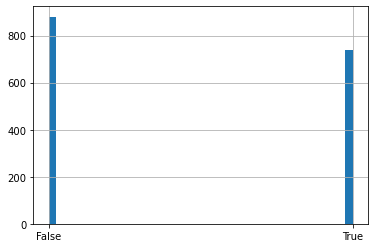

In [17]:
data['Relevant_Tweets'].value_counts()
data['Relevant_Tweets'].hist(bins=40)

In [18]:
# Lets see how the irrelevant tweets look
print(data['Text'].where(data['Relevant_Tweets'] == "False"))

0       didi abusing bjp unnecessarily mistaken bjp co...
1                                                     NaN
2                                                     NaN
3                                                     NaN
4                                                     NaN
                              ...                        
1613    pm launches agriculture infrastructure fund ne...
1614    pm launches financing facility worth rs lakh c...
1615    pm launch financing facility rs lakh crore agr...
1616    pm narendra modi launch financing facility rs ...
1617    shri shivajirao patil nilangekar stalwart maha...
Name: Text, Length: 1618, dtype: object


<Figure size 720x720 with 0 Axes>

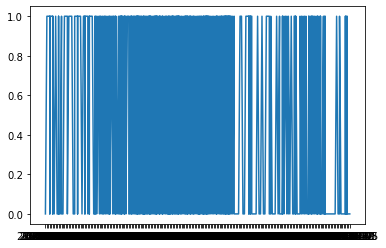

<Figure size 720x720 with 0 Axes>

In [21]:
# Consistency of farmer protest related tweets
plt.plot(data['Datetime'], data['Relevant_Tweets']== "True")
plt.figure(figsize= (10,10))

In [23]:
# freq['Date'] = pd.date_range(start='01/08/2020', end='14/04/2021')

# All tweets in the dataframe below are supposedly relevant.
freq = data[data["Relevant_Tweets"] == "True"]
# freq.info()
freq.head(20)

,Datetime,Text,Original_Tweets,Keywords,Relevant_Tweets
1,2021-04-11,citing covid tomar asks farmers call stir come...,"Citing Covid, Tomar asks farmers to call off t...","[citing, covid, asks, come, call, stir, tomar,...",True
2,2021-04-10,tomar appeals farmers call protest covid cases...,#FarmersProstest\n\nTomar appeals to farmers t...,"[surge, cases, appeals, covid, call, ready, to...",True
3,2021-04-10,many farmers unions economists supporting agri...,"Many farmers unions, economists are supporting...","[bills, unions, talks, protesting, economists,...",True
4,2021-04-09,surrendered modi shiromani akali dal amarinder...,You have surrendered to Modi: Shiromani Akali ...,"[surrendered, dbt, payment, shiromani, akali, ...",True
5,2021-04-09,protesting farmers block kmp kgp expressway 24...,#FarmersProtests\n\nProtesting farmers to bloc...,"[morning, kgp, saturday, kmp, expressway, hour...",True
6,2021-04-09,punjab bows centre agrees transfer cash direct...,"Punjab bows to Centre, agrees to transfer cash...","[bows, transfer, cash, agrees, directly, centr...",True
7,2021-04-09,even fear disrupt protest say agitating farmers,"Not even fear of #COVID19 can disrupt protest,...","[disrupt, fear, even, agitating, say, protest,...",True
8,2021-04-09,spurt covid like symptoms singhu border farmer...,"Spurt in Covid-like symptoms at Singhu border,...","[tests, spurt, keen, symptoms, covid, like, si...",True
11,2021-04-09,punjab bows centre agrees transfer cash direct...,"Punjab bows to Centre, agrees to transfer cash...","[bows, transfer, cash, agrees, directly, centr...",True
12,2021-04-08,six caught billionaire farmer murder gujarat,Six caught for billionaire farmer’s murder in ...,"[billionaire, murder, caught, six, gujarat, fa...",True


In [24]:
# Create a frequency column to calculate number of relevant tweets per day --> signifying urgency
freq = freq.groupby(['Datetime', 'Relevant_Tweets']).size().to_frame('frequency').reset_index()
freq.head(5)

,Datetime,Relevant_Tweets,frequency
0,2020-08-09,True,1
1,2020-08-10,True,1
2,2020-08-19,True,1
3,2020-08-24,True,1
4,2020-09-14,True,1


In [25]:
# Confirming calculations
freq['frequency'].sum()

738

In [26]:
# Distribution of Frequencies stats
freq['frequency'].value_counts()

1     52
2     26
5     13
4     12
3     12
7     11
8      7
10     6
9      6
6      4
16     3
14     3
13     3
11     3
17     2
18     1
Name: frequency, dtype: int64

<Figure size 1440x1440 with 0 Axes>

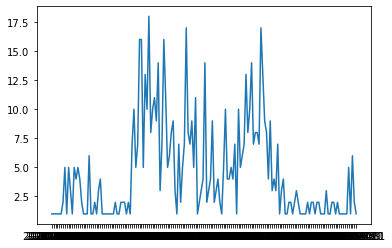

<Figure size 1440x1440 with 0 Axes>

In [27]:
# Distribution of Frequencies plot
plt.plot(freq['Datetime'], freq['frequency'])
plt.figure(figsize= (20,20))

In [28]:
# Checking date of highest frequency farmer related tweets
print(freq[freq['frequency'] == 18])

      Datetime Relevant_Tweets  frequency
52  2020-12-05            True         18


In [29]:
# creating new dataframe for experimentation
freq1 = data[data["Relevant_Tweets"] == "True"]
# freq1
freq1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 738 entries, 1 to 1612
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Datetime         738 non-null    object
 1   Text             738 non-null    object
 2   Original_Tweets  738 non-null    object
 3   Keywords         738 non-null    object
 4   Relevant_Tweets  738 non-null    object
dtypes: object(5)
memory usage: 34.6+ KB


In [30]:
# freq1= freq1.groupby(['Datetime'])['Relevant_Tweets'].apply(', '.join).reset_index()
freq1= freq1.groupby(['Datetime']).sum().reset_index()
freq1

,Datetime,Text,Original_Tweets,Keywords,Relevant_Tweets
0,2020-08-09,pm kisan scheme benefited 52 lakh farmers karn...,PM Kisan scheme benefited 52.5 lakh farmers in...,"[benefited, 52, yediyurappa, bs, karnataka, sc...",True
1,2020-08-10,punjab farmer objects use farm ordinance campaign,Punjab farmer objects to use of photo in farm ...,"[objects, ordinance, campaign, use, punjab, fa...",True
2,2020-08-19,china rat cobra farmers feel coronavirus pain,"China's rat, cobra farmers feel coronavirus pa...","[rat, coronavirus, cobra, feel, pain, china, f...",True
3,2020-08-24,mushroom delhi farmer fly 21 workers,Mushroom for more: Delhi farmer to fly in 21 w...,"[mushroom, fly, 21, workers, farmer, delhi]",True
4,2020-09-14,msp stay farmers get investment technology gov...,"MSP will stay, farmers will get investment, te...","[technology, investment, stay, sector, get, bi...",True
...,...,...,...,...,...
159,2021-04-07,govt treat farmers stir like shaheen bagh prot...,Govt shouldn't treat farmers' stir like Shahee...,"[treat, shaheen, bagh, like, rakesh, tikait, s...",TrueTrueTrueTrueTrue
160,2021-04-08,six caught billionaire farmer murder gujarat,Six caught for billionaire farmer’s murder in ...,"[billionaire, murder, caught, six, gujarat, fa...",True
161,2021-04-09,surrendered modi shiromani akali dal amarinder...,You have surrendered to Modi: Shiromani Akali ...,"[surrendered, dbt, payment, shiromani, akali, ...",TrueTrueTrueTrueTrueTrue
162,2021-04-10,tomar appeals farmers call protest covid cases...,#FarmersProstest\n\nTomar appeals to farmers t...,"[surge, cases, appeals, covid, call, ready, to...",TrueTrue


In [31]:
freq1['frequency']= ""
freq1['frequency'] = freq['frequency']
freq1 = freq1.drop(['Relevant_Tweets'], axis=1)
freq1

,Datetime,Text,Original_Tweets,Keywords,frequency
0,2020-08-09,pm kisan scheme benefited 52 lakh farmers karn...,PM Kisan scheme benefited 52.5 lakh farmers in...,"[benefited, 52, yediyurappa, bs, karnataka, sc...",1
1,2020-08-10,punjab farmer objects use farm ordinance campaign,Punjab farmer objects to use of photo in farm ...,"[objects, ordinance, campaign, use, punjab, fa...",1
2,2020-08-19,china rat cobra farmers feel coronavirus pain,"China's rat, cobra farmers feel coronavirus pa...","[rat, coronavirus, cobra, feel, pain, china, f...",1
3,2020-08-24,mushroom delhi farmer fly 21 workers,Mushroom for more: Delhi farmer to fly in 21 w...,"[mushroom, fly, 21, workers, farmer, delhi]",1
4,2020-09-14,msp stay farmers get investment technology gov...,"MSP will stay, farmers will get investment, te...","[technology, investment, stay, sector, get, bi...",1
...,...,...,...,...,...
159,2021-04-07,govt treat farmers stir like shaheen bagh prot...,Govt shouldn't treat farmers' stir like Shahee...,"[treat, shaheen, bagh, like, rakesh, tikait, s...",5
160,2021-04-08,six caught billionaire farmer murder gujarat,Six caught for billionaire farmer’s murder in ...,"[billionaire, murder, caught, six, gujarat, fa...",1
161,2021-04-09,surrendered modi shiromani akali dal amarinder...,You have surrendered to Modi: Shiromani Akali ...,"[surrendered, dbt, payment, shiromani, akali, ...",6
162,2021-04-10,tomar appeals farmers call protest covid cases...,#FarmersProstest\n\nTomar appeals to farmers t...,"[surge, cases, appeals, covid, call, ready, to...",2


In [32]:
freq1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Datetime         164 non-null    object
 1   Text             164 non-null    object
 2   Original_Tweets  164 non-null    object
 3   Keywords         164 non-null    object
 4   frequency        164 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 6.5+ KB


In [33]:
freq1['Datetime'] = pd.to_datetime(freq1['Datetime'], format='%Y-%m-%d')
freq1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Datetime         164 non-null    datetime64[ns]
 1   Text             164 non-null    object        
 2   Original_Tweets  164 non-null    object        
 3   Keywords         164 non-null    object        
 4   frequency        164 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.5+ KB


In [34]:
freq1.iloc[104]

Datetime                                         2021-01-26 00:00:00
Text               83 police personnel injured attacked agitating...
Original_Tweets    83 Police personnel were injured after being a...
Keywords           [83, police, attacked, injured, personnel, del...
frequency                                                         13
Name: 104, dtype: object

In [35]:
freq1.iloc[104]['Keywords']

['83',
 'police',
 'attacked',
 'injured',
 'personnel',
 'delhi',
 'agitating',
 'today',
 'protest',
 'farmers',
 'timeline',
 'turned',
 'brief',
 'violent',
 'rally',
 'tractor',
 'day',
 'farmers',
 'internet',
 'suspended',
 'services',
 'enter',
 'red',
 'fort',
 'key',
 'developments',
 'protesting',
 'protest',
 'affected',
 'parts',
 'traffic',
 'due',
 'rally',
 'tractor',
 'delhi',
 'farmers',
 'mild',
 'resort',
 'lathicharge',
 'premises',
 'remove',
 'red',
 'fort',
 'police',
 'protesting',
 'protest',
 'complex',
 'enter',
 'red',
 'fort',
 'key',
 'developments',
 'protesting',
 'farmers',
 'peace',
 'peaceful',
 'maintain',
 'urges',
 'rally',
 'country',
 'tractor',
 'cm',
 'punjab',
 'farmers',
 'peace',
 'peaceful',
 'maintain',
 'urges',
 'country',
 'cm',
 'punjab',
 'farmers',
 'stunt',
 'performs',
 'participates',
 'bike',
 'gantantra',
 'parade',
 'kisan',
 'centre',
 'protest',
 'farmer',
 'red',
 'fort',
 'reach',
 'protesting',
 'delhi',
 'farmers',
 'cop